In [2]:
# Moduły

import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.animation as ani

ZADANIE 1

In [27]:
# stałe

boltzmann = 1
dt = 0.001
mass = 1
part_num = 16
rad = 0.75
temp_we_deserve = 0.5

# klasa cząstki

class particle:
    def __init__(self, position, velocity):
        self.x = position
        self.v = velocity

# odległość między cząstkami

def d(P1, P2):
    return np.sqrt((P1.x[0] - P2.x[0])**2 + (P1.x[1] - P2.x[1])**2)

# zwraca kopię cząstki R najbliższą do cząstki P

def closest_image(P, R):
    Q = particle(R.x.copy(), R.v.copy())

    if P.x[0] - Q.x[0] > 2.5:
        Q.x[0] += 5
    elif P.x[0] - Q.x[0] < -2.5:
        Q.x[0] -= 5

    if P.x[1] - Q.x[1] > 2.5:
        Q.x[1] += 5
    elif P.x[1] - Q.x[1] < -2.5:
        Q.x[1] -= 5

    return Q

# funkcje ds. dynamiki

def half_v_step(list_of_particles, P):
    force_combined = np.array([0., 0.])
    for R in list_of_particles:
        if R == P:
            continue
        force_combined += force(P, closest_image(P, R))
    return P.v + force_combined / mass / 2 * dt

def compute_mi(list_of_particles):
    molecules = list_of_particles.copy()
    for M in molecules:
        M.v = half_v_step(molecules, M)
    temp_we_have = tempForNow(molecules)
    return np.sqrt(temp_we_deserve / temp_we_have)

def v_step(P, mi, list_of_particles):
    force_combined = np.array([0., 0.])
    for R in list_of_particles:
        if R == P:
            continue
        force_combined += force(P, closest_image(P, R))
    return (2*mi - 1) * P.v + mi * force_combined / mass * dt

def x_step(P):
    newX = P.x + P.v * dt
    if newX[0] < 0:
        newX[0] += 5
    if newX[1] < 0:
        newX[1] += 5
    if newX[0] > 5:
        newX[0] -= 5
    if newX[1] > 5:
        newX[1] -= 5
    return newX

# funkcja siły jaką cząstka P2 działa na P1

def force(P1, P2):
    if d(P1, P2) > 2.5 * rad:
        return np.array((0, 0))
    else:
        total_force = 48 / rad * ((rad / d(P1, P2))**13 - 0.5 * (rad / d(P1, P2))**7)
        force_1 = total_force / d(P1, P2) * (P1.x[0] - P2.x[0])
        force_2 = total_force / d(P1, P2) * (P1.x[1] - P2.x[1])
        return np.array([force_1, force_2])

# funkcja "ciśnienia" miedzy cząsteczkami

def dual_pressure(P1, P2):
    out1 = force(P1, P2)[0] * (P1.x[0] - P2.x[0])
    out2 = force(P1, P2)[1] * (P1.x[1] - P2.x[1])
    return out1 + out2

# funkcja chwilowej temperatury

def tempForNow(list_of_particles):
    kin_energy = 0
    for P in list_of_particles:
        kin_energy += (P.v[0]**2 + P.v[1]**2)
    kin_energy *= (mass / 2)
    temperature = kin_energy / boltzmann / part_num
    return temperature

# inicjalizacja cząstek

particles = []
for i in range(part_num):
    x = np.array([i // np.sqrt(part_num) + 1, i % np.sqrt(part_num) + 1])
    v = np.random.uniform(-4, 4, 2)
    A = particle(x, v)
    particles.append(A)

# obliczenia numeryczne

total_time = 15
step_num = math.floor(total_time / dt)
print_time = 30

frames = np.empty([math.floor(total_time / dt / print_time), 2, part_num])
temperatures = []
pressures = []

for steps in range(step_num):

    mi = compute_mi(particles)
    for P in particles:
        P.v = v_step(P, mi, particles)
    for P in particles:
        P.x = x_step(P)

    if steps % print_time == 0:
        frames[math.floor(steps / print_time), 0, :] = [P.x[0] for P in particles]
        frames[math.floor(steps / print_time), 1, :] = [P.x[1] for P in particles]

    temperatures.append(tempForNow(particles))
    pressures.append(temperatures[steps] * 16 / 25 * boltzmann)
    for P1 in particles:
        for P2 in particles:
            if P1 == P2:
                 continue
            pressures[steps] += dual_pressure(P1, P2) / 50

plt.close()


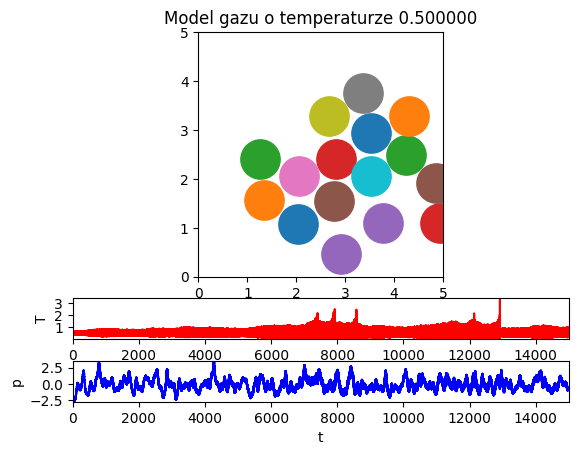

In [28]:
# ANIMACJA

background, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw = {'height_ratios' : [6, 1, 1]})   # tworzymy figurę

ax1.set_ylim(0, 5)
ax1.set_xlim(0, 5)
ax1.set_aspect(1)
ax1.set_title('Model gazu o temperaturze %f' %temp_we_deserve)

tempPic, = ax2.plot([], [], color = 'red')
ax2.set_xlim(0, len(temperatures))
ax2.set_ylim(min(temperatures), max(temperatures))
ax2.set_xlabel("t")
ax2.set_ylabel("T")

pressPic, = ax3.plot([], [], color = 'blue')
ax3.set_xlim(0, len(pressures))
ax3.set_ylim(min(pressures), max(pressures))
ax3.set_xlabel("t")
ax3.set_ylabel("p")

Pics = [tempPic, pressPic,]
for i in range(part_num):
    Pics.append(ax1.scatter([], [], s = 800))

def animate(i):
    Pics[0].set_data([range(len(temperatures[0 : print_time * i]))], temperatures[0 : print_time * i])
    Pics[1].set_data([range(len(pressures[0 : print_time * i]))], pressures[0 : print_time * i])
    for p in range (2, part_num + 2):
        Pics[p].set_offsets([frames[i, 0, p - 2], frames[i, 1, p - 2]])
    return Pics

anim = ani.FuncAnimation(background, animate, frames = math.floor(total_time / dt / print_time), interval = 200, blit = 'True')
anim.save('woda.gif', writer = 'ffmpeg', fps = 30)
